# Cosine Similarity 

In [22]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import nltk 
from nltk import *
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB


from nltk.probability import FreqDist
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')

### Data Information

Given the title of a fake news article A and the title of a coming news article B, participants are asked to classify B into one of the three categories.

- agreed: B talks about the same fake news as A
- disagreed: B refutes the fake news in A
- unrelated: B is unrelated to A

### Data fields

- id - the id of each news pair.
- tid1 - the id of fake news title 1.
- tid2 - the id of news title 2.
- title1_zh - the fake news title 1 in Chinese.
- title2_zh - the news title 2 in Chinese.
- title1_en - the fake news title 1 in English.
- title2_en - the news title 2 in English.
- label - indicates the relation between the news pair: agreed/disagreed/unrelated.
- The English titles are machine translated from the related Chinese titles. This may help participants from all background to get better understanding of the datasets. Participants are highly recommended to use the Chinese version titles to finish the task.

### File type

- train.csv - training data contains 320,767 news pairs in both Chinese and English. This file provides the only data you can use to finish the task. Using external data is not allowed.

In [23]:
def load_data(path):
    
    data = pd.read_csv(path)
    data = data.set_index("id")
    data = data.sort_index()
    
    return data 

### Approach 

We have to come up with an idea to match Title 1 and Title 2  that can give a probability distribution describing the boundary condition for each of the three classes. The following are the ways we can do: -

1) Let's try to find cosine similarity of the two titles. This can be our random variable and we can check whether it can help us to classify the random variable. 

-  Tokenize 
-  Form a uniform vector 
-  find the cosine of the two vector.

### Applying Cosine Similarity 

******************

1) TextProcessing :- Three functions are created to find the final vector of each title. Combining all the three functions below, TextProcessing function is created.  
- RemovePunctuation : Function to remove punctuaiton from the text documents 
- Tokenize : Function to tokenize the text document. Returns a list of array where each element is token. 
- StopWordRemoval : Function to remove the Stop words from the text documents. 
- Lemmatization : Function to remove the prefix and suffix of the words and return the lemma of the word. 

In [24]:
## Function to remove Punctuation from the string, even attached to the word. 
def RemovePunctuation(my_str):
    punctuations = string.punctuation
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char.lower()
            
    return no_punct

In [25]:
## Tokenize the string
def Tokenize(my_str):
    text = my_str.split()
    return text

In [37]:
## Remove Stop Word 
stopwords = set(stopwords.words('english'))
def StopWordRemoval(my_str):
    
    l = [word for word in my_str if word not in stopwords]
    return l

In [36]:
## Remove Suffix and prefix from the word. 
lemmatizer = WordNetLemmatizer()
def lemma(my_str):
    
    l = [lemmatizer.lemmatize(word) for word in my_str]
    return l

In [28]:
## Applying the above functions altogether
def TextProcessing(text):
    
    text = RemovePunctuation(text)
    text = Tokenize(text)
    text = StopWordRemoval(text)
    text = lemma(text)
    
    return text

2) BagOfWords :- This function create a set of all the unique words (tokens) in the two titles (title 1 and title 2). We shall use this to create a seperate column in the dataframe consisting of all the unique words in the two titles.

In [29]:
def BagOfWords(list_str):
    dic =  list(set(list_str))
    return dic

3) TermFrequency :- This function will find the frequency of each word of the dictionary in the given list. This function returns a  frequency vector of a size equivalent to the size of the dictionary. In can take a nested list in the form of Numpy array. 

In [30]:
def TermFrequency(dictionary, text ):
    length = len(dictionary)
    freq_list = []
    for ii in range(length):
        dic_list = dictionary[ii]
        text_list = text[ii]
        freq = []
        for i in range(len(dic_list)):
            freq.append(text_list.count(dic_list[i]))
        freq_list.append(np.array(freq))
        
    return np.array(freq_list)

4) L2 and Cosine : L2 function is calculate the L2 norm of the vector on the other end, Cosine is calculate the cosine of the angle between the two vectors 

In [31]:
def L2(vector):
    norm_value = np.linalg.norm(vector)
    return norm_value

In [32]:
def Cosine(fr1, fr2):
    cos = np.dot(fr1, fr2)/(L2(fr1)*L2(fr2))
    return cos

**********************

##### Applying the above define funcitons on dataset

In [33]:
def preprocess(data):
    """Creating another dataframe in to process the text """
    df = data[["title1_en", "title2_en"]]
    
    """Applying TextProcessing function"""
    df["title1_en"] = df["title1_en"].apply(lambda x: TextProcessing(x))
    df["title2_en"] = df["title2_en"].apply(lambda x: TextProcessing(x))
    
    """Creating Dictionary column by adding tile1_en and title2_en and applying Dictionary function to"""
    df["BagOfWords"] = df['title1_en'] + df["title2_en"]
    df.BagOfWords = df.BagOfWords.map(BagOfWords)
    
    # Creating "TF1" and "TF2" variable containing a list of Frequency for each word in title1 and title 2 and
    # adding a column for Cosine Similarity. 
    df["TF1"] = TermFrequency(df.BagOfWords.values, df.title1_en.values)
    df["TF2"] = TermFrequency(df.BagOfWords.values, df.title2_en.values)
    df["Cosine_similarity"] = np.vectorize(Cosine)(df["TF1"], df["TF2"])
    return df

### Computing Cosine of the vector

In [34]:
## Loading data
data = load_data("train.csv")
data.head()

,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
id,,,,,,,
0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
4,2,8,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？统计局辟谣：未超但差距再度缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated


## Computing the Cosine of the vector

In [38]:
df = preprocess(data)

In [39]:
df.head()

,title1_en,title2_en,BagOfWords,TF1,TF2,Cosine_similarity
id,,,,,,
0,"[two, new, oldage, insurance, benefit, old, pe...","[police, disprove, bird, nest, congress, perso...","[old, got, congress, new, insurance, bird, old...","[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","[1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, ...",0.163299
1,"[come, shenzhen, sooner, later, son, also, com...","[gdp, overtopped, hong, kong, shenzhen, clarif...","[kong, le, also, shenzhen, hong, clarified, co...","[1, 1, 1, 2, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 0, ...","[1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, ...",0.385758
2,"[come, shenzhen, sooner, later, son, also, com...","[shenzhens, gdp, topped, hong, kong, last, yea...","[kong, bureau, billion, le, also, last, topped...","[1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1, ...","[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...",0.349927
3,"[come, shenzhen, sooner, later, son, also, com...","[shenzhens, gdp, outstrips, hong, kong, shenzh...","[kong, bureau, narrowing, le, also, shenzhen, ...","[1, 0, 0, 1, 1, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, ...","[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...",0.314970
4,"[come, shenzhen, sooner, later, son, also, com...","[shenzhens, gdp, overtakes, hong, kong, bureau...","[kong, bureau, le, also, shenzhen, shrink, she...","[1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1, ...","[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, ...",0.188982


In [77]:
## Creating a dataframe with Cosine_similarity and the lebel
prob_dist = pd.concat([df.Cosine_similarity, data.label], axis=1)
prob_dist = prob_dist.fillna(value=0)
prob_dist = prob_dist.reset_index()[["Cosine_similarity","label"]]

## Class wise data segregation
unrelated =  prob_dist[prob_dist["label"] == 'unrelated']
agreed = prob_dist[prob_dist["label"] == 'agreed']
disagreed = prob_dist[prob_dist["label"] == 'disagreed']

## Cosine Similarity

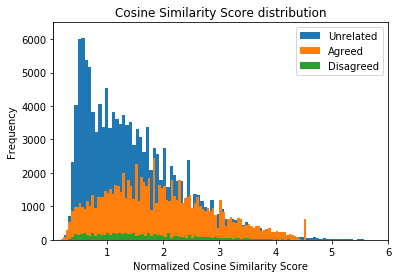

In [42]:
plt.hist(unrelated.Cosine_similarity/unrelated.Cosine_similarity.std() , label= "Unrelated", bins= 100)
plt.hist(agreed.Cosine_similarity/agreed.Cosine_similarity.std(), label= "Agreed", bins= 100)
plt.hist(disagreed.Cosine_similarity/disagreed.Cosine_similarity.std() , label= "Disagreed", bins= 100)
plt.ylim(0,6500)
plt.xlim(0.05,6)
plt.xlabel("Normalized Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Score distribution")
plt.legend()
plt.savefig("Cosine_similarity_distribution.png", dpi= 1000)

## Classifier 

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def classifier(data, label, size):
        """Classification analysis is done using 4 different classifiers. Function returns the performance score
        of each of the classifier"""
        from sklearn.metrics import jaccard_similarity_score
        
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=size, random_state=42)
        
        # Bayesian Classifier 
        gnb = GaussianNB()
        gnb_clf = gnb.fit(X_train, y_train)
        score1 = gnb_clf.score(X_test, y_test)
        y_pred1 = gnb_clf.predict(X_test)
        js1 = jaccard_similarity_score(y_test, y_pred1)
        
        # Logisitic Regression Classifier
        logisitc_clf= LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
        logistic_clf = logisitc_clf.fit(X_train, y_train)
        score2 = logistic_clf.score(X_test, y_test)
        y_pred2 = logistic_clf.predict(X_test)
        js2 = jaccard_similarity_score(y_test, y_pred2)
        
        # Random Forest Classifier 
        Randomforest_clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
        rfc_clf = Randomforest_clf.fit(X_train, y_train)
        score3 = rfc_clf.score(X_test, y_test)
        y_pred3 = rfc_clf.predict(X_test)
        js3 = jaccard_similarity_score(y_test, y_pred3)
        
        # LDA 
        LDA = LinearDiscriminantAnalysis()
        LDA_clf = LDA.fit(X_train, y_train)
        score4 = LDA_clf.score(X_test, y_test)
        y_pred4 = LDA_clf.predict(X_test)
        js4 = jaccard_similarity_score(y_test, y_pred4)

        
        print("Naive Bayes Classifier score:=  " + str(score1)) #+ "&" + str(js1)), \
        print("Logistic Regression Classifier score:=  " + str(score2))#+ "&" + str(js2)), \
        print("Random Forest Classifier score:=  " + str(score3))#+ "&" + str(js3)), \
        print("LDA Classifier score:=  " + str(score4))#+ "&" + str(js4))
        
        return gnb_clf, logistic_clf, rfc_clf, LDA_clf

In [45]:
def ConfusionMatrix(y_true, y_pred, classes,normalize=True, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [78]:
Dummy = [1]*320492
X = pd.concat([prob_dist[["Cosine_similarity"]], pd.DataFrame(Dummy)], axis=1)
X.columns = ['Cosine_similarity', "Dummy"]
y = prob_dist[['label']]

In [80]:
classifier(X,y , 0.25)

Naive Bayes Classifier score:=  0.7586086392172036
Logistic Regression Classifier score:=  0.7583340613806273
Random Forest Classifier score:=  0.752118617625401
LDA Classifier score:=  0.7580594835440511


(GaussianNB(priors=None, var_smoothing=1e-09),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='multinomial',
           n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
           tol=0.0001, verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
 LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
               solver='svd', store_covariance=False, tol=0.0001))